### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
#Hay tweets repetidos, eliminar?
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


### Cantidad de reales vs falsos

In [8]:
tweets['target'].value_counts(normalize=True)

0    0.576271
1    0.423729
Name: target, dtype: float64

### Top ciudades mentirosas/dicen la verdad

In [9]:
#No me importan las locaciones NAN
partial = tweets.dropna()

In [10]:
partial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4982 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4982 non-null   int64 
 1   keyword   4982 non-null   object
 2   location  4982 non-null   object
 3   text      4982 non-null   object
 4   target    4982 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 233.5+ KB


In [11]:
locations = partial[partial['location'].str.match(r'^([a-zA-Z,\s])*$') > 0]
locations.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [12]:
locations.loc[:, 'location'] = locations.location.str.lower()

/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3946 non-null   int64 
 1   keyword   3946 non-null   object
 2   location  3946 non-null   object
 3   text      3946 non-null   object
 4   target    3946 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 185.0+ KB


In [14]:
locations.head()

,id,keyword,location,text,target
31,48,ablaze,birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"philadelphia, pa",Crying out for more! Set me ablaze,0
35,53,ablaze,"london, uk",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [15]:
#20 lugares con mas tweets
top_20_locations = locations['location'].value_counts().nlargest(20).to_frame()
top_20_locations

,location
usa,104
new york,75
united states,50
london,49
canada,33
worldwide,29
uk,29
"los angeles, ca",28
nigeria,25
india,24


Text(0.5, 0, 'Location')

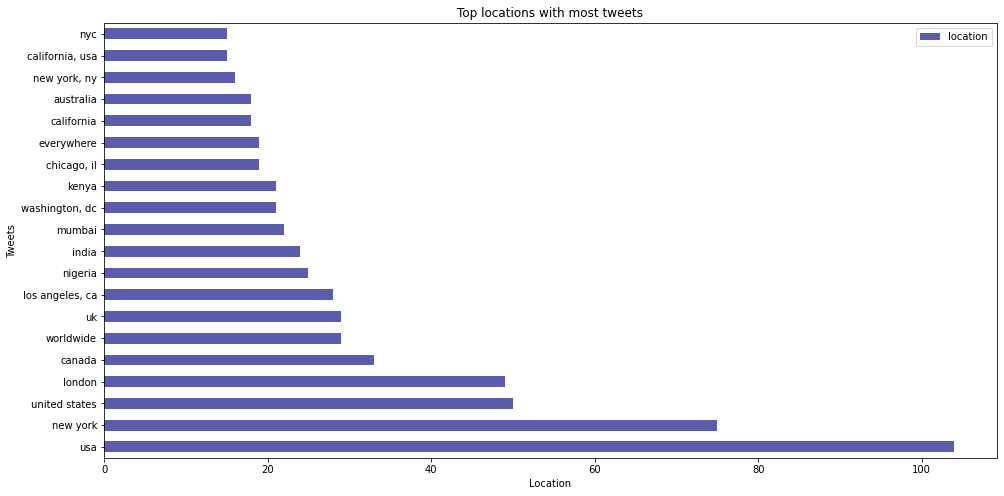

In [16]:
top_20_locations.plot(kind='barh',  rot=0, title='Top locations with most tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [17]:
locations.head()

,id,keyword,location,text,target
31,48,ablaze,birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"philadelphia, pa",Crying out for more! Set me ablaze,0
35,53,ablaze,"london, uk",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [18]:
by_location = locations.groupby(['location']).agg({'target':['count', 'sum']})
level_0 = by_location.columns.get_level_values(0)
level_1 = by_location.columns.get_level_values(1)
by_location.columns = level_0 + '_' + level_1
by_location.reset_index(inplace=True)
by_location.head()

,location,target_count,target_sum
0,,1,1
1,glasgow,1,0
2,"melbourne, australia",1,0
3,news,1,1
4,alberta,1,1


In [19]:
by_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      2271 non-null   object
 1   target_count  2271 non-null   int64 
 2   target_sum    2271 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.4+ KB


In [20]:
import os.path
if(not os.path.isfile('locations.csv')):
    get_geodata()

def get_geodata():
    from geopy.geocoders import Nominatim
    from tqdm import tqdm
    from geopy.extra.rate_limiter import RateLimiter
    geolocator = Nominatim(user_agent="mile.marchese@gmail.com")
    tqdm.pandas()
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2, max_retries=0)
    by_location['geodata'] = by_location['location'].progress_apply(geocode)
    by_location['address'] = by_location['geodata'].apply(lambda loc: loc.address if loc else None)
    by_location['point'] = by_location['geodata'].apply(lambda loc: tuple(loc.point) if loc else None)
    by_location.to_csv('locations.csv', index=False)

In [21]:
address = pd.read_csv('locations.csv', usecols=['location', 'target_count', 'target_sum', 'address']) 
address.head()

,location,target_count,target_sum,address
0,,1,1,NaN
1,glasgow,1,0,"Glasgow, Glasgow City, Scotland, G2 9SA, Unite..."
2,"melbourne, australia",1,0,"City of Melbourne, Victoria, Australia"
3,news,1,1,"34375, Abbotsford Centre, Abbotsford, Fraser V..."
4,alberta,1,1,"Alberta, Canada"


In [22]:
#Hay 374 que geopy no encontró
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      2271 non-null   object
 1   target_count  2271 non-null   int64 
 2   target_sum    2271 non-null   int64 
 3   address       1880 non-null   object
dtypes: int64(2), object(2)
memory usage: 71.1+ KB


In [23]:
#Se puede correr de nuevo geopy 
not_found_addr = address[address['address'].isnull()]
not_found_addr.head()

,location,target_count,target_sum,address
0,,1,1,NaN
8,indiana,1,0,NaN
9,jariana town,1,0,NaN
12,"nevada carson city,freeman st",1,1,NaN
16,nxgerxa,1,0,NaN


In [24]:
not_found_addr['target_count'].value_counts(normalize=True)

1    0.941176
2    0.038363
3    0.015345
6    0.002558
4    0.002558
Name: target_count, dtype: float64

In [25]:
address['address'].describe()

count                                   1880
unique                                  1430
top       New York, United States of America
freq                                      15
Name: address, dtype: object

In [26]:
by_address = address.groupby(['address']).agg({'target_count':'sum', 'target_sum': 'sum'\
                                               , 'location': lambda x: "%s" % '-'.join(set(x))}).reset_index()
by_address.head()

,address,target_count,target_sum,location
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca"


In [27]:
by_address.columns = ['address', 'total', 'real', 'location_list']

In [28]:
by_address['fake'] = by_address['total'] - by_address['real']
by_address.head()

,address,total,real,location_list,fake
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov,1
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route,0
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows,0
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa,1
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca",1


In [29]:
by_address.describe()

,total,real,fake
count,1430.000000,1430.000000,1430.000000
mean,2.461538,1.100699,1.360839
std,7.133800,3.632477,3.987893
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,168.000000,103.000000,98.000000


In [30]:
#10 ciudades que mas reales tienen
most_real = by_address.nlargest(10, 'real').loc[:, ['address', 'real']].set_index('address')
most_real

,real
address,
United States,103
"New York, United States of America",40
"London, Greater London, England, SW1A 2DX, United Kingdom",26
"Mumbai, Mumbai City, Maharashtra, India",22
Nigeria,22
United Kingdom,20
"Washington, District of Columbia, 20500, United States of America",19
भारत - India,19
"Calgary, Alberta, Canada",18


Text(0, 0.5, 'Location')

/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2349 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/matiascano/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2349 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/

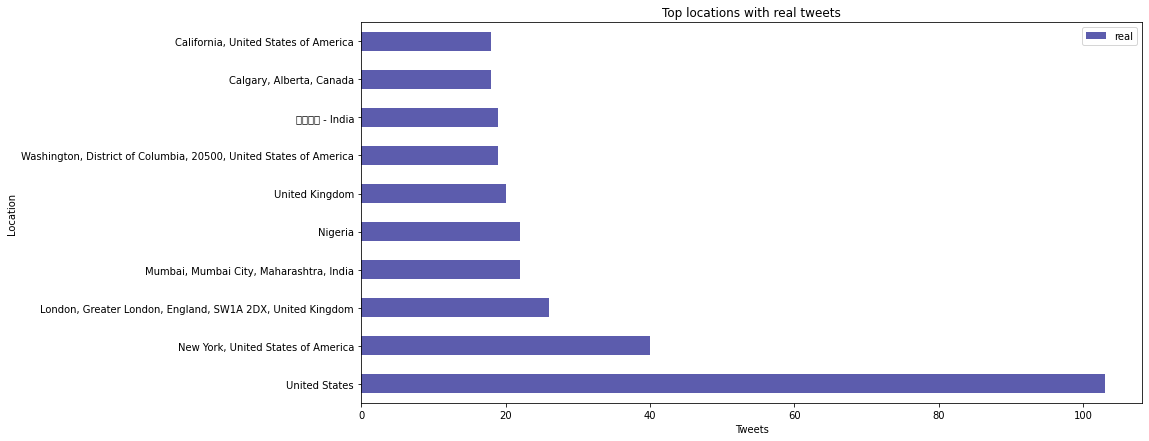

In [31]:
most_real.plot(kind='barh',  rot=0, title='Top locations with real tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

In [32]:
#10 ciudades que mas falsos tienen
most_fake = by_address.nlargest(10, 'fake').loc[:,['address', 'fake']].set_index('address')
most_fake

,fake
address,
"New York, United States of America",98
United States,65
"London, Greater London, England, SW1A 2DX, United Kingdom",49
"Los Angeles, Los Angeles County, California, United States of America",32
"California, United States of America",24
United Kingdom,24
Canada,20
"Texas, United States of America",20
"Chicago, Cook County, Illinois, United States of America",19


Text(0, 0.5, 'Location')

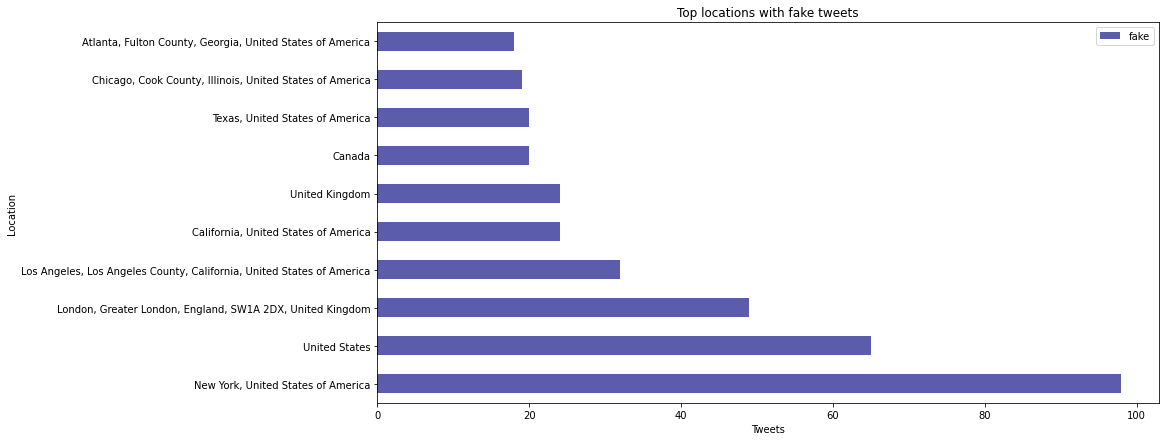

In [33]:
most_fake.plot(kind='barh',  rot=0, title='Top locations with fake tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

In [34]:
by_address.describe()

,total,real,fake
count,1430.000000,1430.000000,1430.000000
mean,2.461538,1.100699,1.360839
std,7.133800,3.632477,3.987893
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,168.000000,103.000000,98.000000


### Locaciones no encontradas

In [35]:
not_found_addr.head()

,location,target_count,target_sum,address
0,,1,1,NaN
8,indiana,1,0,NaN
9,jariana town,1,0,NaN
12,"nevada carson city,freeman st",1,1,NaN
16,nxgerxa,1,0,NaN


In [36]:
not_found_addr = not_found_addr.drop(columns=['address'])
not_found_addr.columns = ['location', 'total', 'real']

In [37]:
grouped_by_fake_loc = not_found_addr.groupby(['location']).agg({'total':'sum', 'real':'sum'}).reset_index()

In [38]:
grouped_by_fake_loc['fake'] = grouped_by_fake_loc['total'] - grouped_by_fake_loc['real']
grouped_by_fake_loc.head()

,location,total,real,fake
0,,1,1,0
1,indiana,1,0,1
2,jariana town,1,0,1
3,"nevada carson city,freeman st",1,1,0
4,nxgerxa,1,0,1


In [39]:
most_used_fake_loc = grouped_by_fake_loc.nlargest(15, 'total')
most_used_fake_loc

,location,total,real,fake
5,road to the billionaires club,6,1,5
88,edinburgh,4,0,4
18,america of founding fathers,3,1,2
29,"bangalore, india",3,1,2
53,buy give me my money,3,0,3
113,financial news and views,3,3,0
115,five down from the coffeeshop,3,2,1
361,washington dc,3,2,1
85,eastcarolina,2,1,1
89,eic,2,1,1


In [40]:
most_used_fake_loc_real = grouped_by_fake_loc.nlargest(15, 'real')
most_used_fake_loc_real

,location,total,real,fake
113,financial news and views,3,3,0
90,"el dorado, arkansas",2,2,0
98,"england, united kingdom",2,2,0
115,five down from the coffeeshop,3,2,1
163,in the potters hands,2,2,0
201,mad as hell,2,2,0
252,reddit,2,2,0
256,roaming around the world,2,2,0
292,somewhere out there,2,2,0
313,swmo,2,2,0


In [41]:
most_used_fake_loc_fake = grouped_by_fake_loc.nlargest(15, 'fake')
most_used_fake_loc_fake

,location,total,real,fake
5,road to the billionaires club,6,1,5
88,edinburgh,4,0,4
53,buy give me my money,3,0,3
18,america of founding fathers,3,1,2
29,"bangalore, india",3,1,2
1,indiana,1,0,1
2,jariana town,1,0,1
4,nxgerxa,1,0,1
6,a botanical garden probably,1,0,1
7,a hoop somewhere,1,0,1


### Top paises participantes

In [43]:
by_address['country'] = by_address['address'].str.split(pat = ",")
by_address.head()

,address,total,real,location_list,fake,country
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov,1,"[(B-40);Terrassa nord;Matadepera, Autopista B..."
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route,0,"[1, Route Y, Lede, Ripley County, Missouri..."
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows,0,"[1, South Rent Car Road, East Haven, Housto..."
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa,1,"[188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ..."
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca",1,"[2551, Woodcreek Oaks Boulevard, Roseville, ..."


In [44]:
by_address.loc[:, 'country'] = by_address.country.map(lambda x: x[-1])

In [45]:
by_address.head()

,address,total,real,location_list,fake,country
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov,1,España
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route,0,United States of America
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows,0,United States of America
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa,1,Armenia
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca",1,United States of America


In [46]:
by_address.loc[:, 'country'] = by_address.country.str.strip()
by_country = by_address.groupby(['country']).agg({'total': 'sum', 'real': 'sum', 'fake': 'sum'}).reset_index().sort_values('total', ascending=False)
by_country.head()

,country,total,real,fake
98,United States of America,1705,700,1005
96,United Kingdom,384,143,241
15,Canada,239,114,125
97,United States,168,103,65
5,Australia,106,57,49


In [47]:
by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 98 to 90
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  133 non-null    object
 1   total    133 non-null    int64 
 2   real     133 non-null    int64 
 3   fake     133 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.2+ KB


In [48]:
countries = pd.Series(by_country.country).to_list()

In [55]:
import re
alpha_space = re.compile('^[a-zA-Z_ ]*$')

to_change = {}
for element in countries:
    coincidences = [s for s in countries if element in s]
    if len(coincidences) > 1:
        name = max(coincidences, key=len)
        if not alpha_space.match(name):
            name = min(coincidences, key=len)
        to_change.update({coincidence:name for coincidence in coincidences if coincidence != name})
    
print(to_change)

{'United States': 'United States of America', 'भारत - India': 'India', 'New Zealand / Aotearoa': 'New Zealand', 'China 中国': '中国', 'Africa': 'South Africa', '日本 (Japan)': '日本', 'Egypt / مصر': 'مصر', 'Saudi Arabia / السعودية': 'السعودية'}


In [56]:
to_change.pop('Africa', None)

'South Africa'

In [57]:
by_country.country = by_country.country.replace(to_change) 

In [58]:
by_country.head()

,country,total,real,fake
98,United States of America,1705,700,1005
96,United Kingdom,384,143,241
15,Canada,239,114,125
97,United States of America,168,103,65
5,Australia,106,57,49


In [59]:
by_country = by_country.groupby(['country']).agg({'total': 'sum', 'real': 'sum', 'fake': 'sum'}).reset_index().sort_values('total', ascending=False)
by_country.nlargest(10, 'total')

,country,total,real,fake
93,United States of America,1873,803,1070
92,United Kingdom,384,143,241
15,Canada,239,114,125
33,India,108,73,35
5,Australia,106,57,49
55,Nigeria,61,43,18
43,Kenya,39,15,24
63,Philippines,39,15,24
38,Italia,34,10,24
66,República Dominicana,32,21,11


In [61]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [74]:
#pip install googletrans
try:
    from googletrans import Translator
    translator = Translator()
    by_country['translated_country'] = by_country['country'].apply(translator.translate, dest='en').apply(getattr, args=('text',))
    by_country.head()
except Exception as e:
    print(e)

In [75]:
by_country

,country,total,real,fake,translated_country
93,United States of America,1873,803,1070,United States of America
92,United Kingdom,384,143,241,United Kingdom
15,Canada,239,114,125,Canada
33,India,108,73,35,India
5,Australia,106,57,49,Australia
...,...,...,...,...,...
86,Togo,1,0,1,Togo
89,Türkmenistan,1,0,1,Turkmenistan
14,Cameroun,1,1,0,Cameroon
96,Zimbabwe,1,1,0,Zimbabwe


In [77]:
world = world.merge(by_country, left_on='name', right_on='translated_country', how='left')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country,total,real,fake,translated_country
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,1.0,1.0,0.0,Tanzania
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,239.0,114.0,125.0,Canada
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,1873.0,803.0,1070.0,United States of America


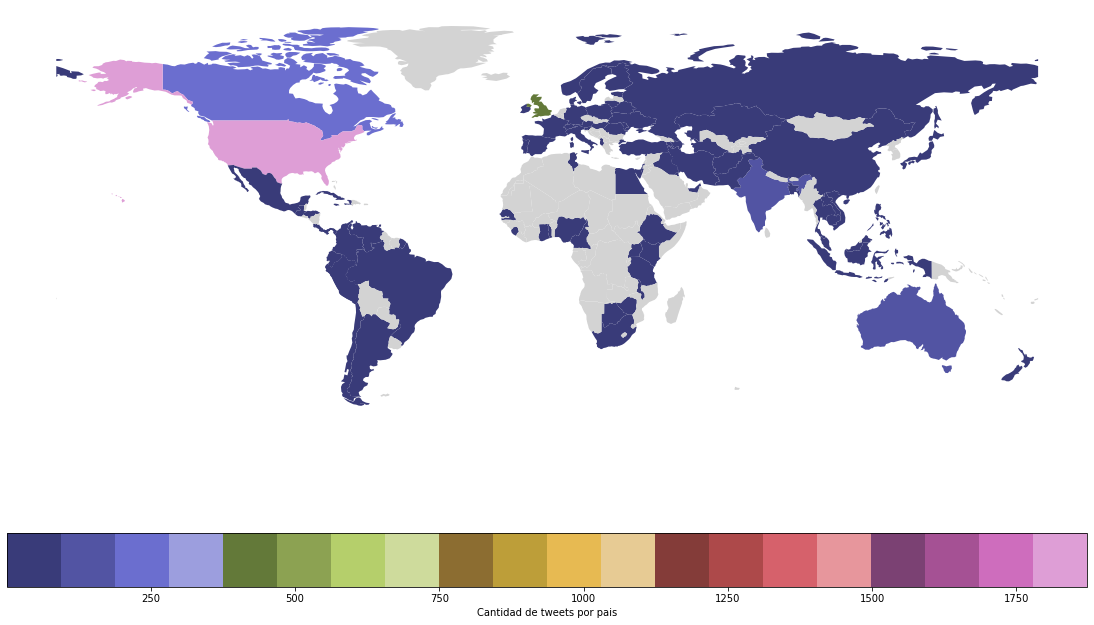

In [100]:
world = world[(world.name!="Antarctica")]
fig= plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
world.plot(column="total", legend=True,\
           legend_kwds={'label': "Cantidad de tweets por pais", 'orientation': "horizontal"},\
           missing_kwds={"color": "lightgrey", "label": "Missing values"}, cmap='tab20b', ax=ax)

In [79]:
top_by_country = by_country.nlargest(10, 'total')

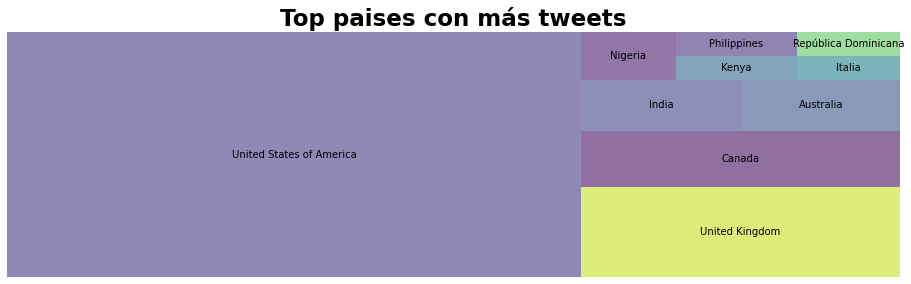

In [104]:
#requirements.txt squarify 0.4.3
import squarify
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min(top_by_country.total), vmax=max(top_by_country.total))
colors = [matplotlib.cm.Blues(norm(value)) for value in top_by_country.total]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)
squarify.plot(label=top_by_country.country,sizes=top_by_country.total, alpha=.6)
plt.title('Top paises con más tweets', fontsize=23, fontweight='bold')
plt.axis('off')
plt.show()

Text(0.5, 0, 'Account')

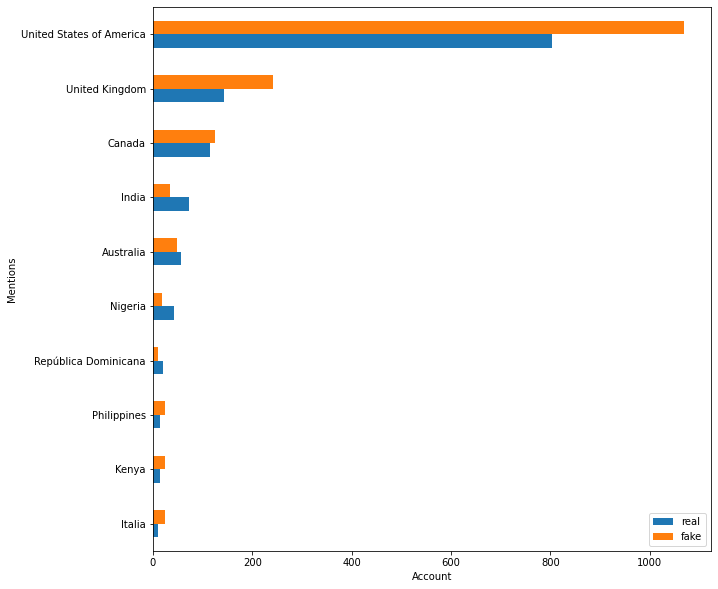

In [105]:
ax = by_country.set_index('country').nlargest(10, 'total').sort_values(by=['real']).loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))
ax.set_ylabel('Mentions')
ax.set_xlabel('Account')

### Personas mas mencionadas

In [106]:
tweets_with_mentions = tweets.loc[tweets['text'].str.contains('@'), ['text', 'target']]
mentions = tweets_with_mentions['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
#La regex encuentra todas las palabras que empiecen con '@' y al mismo tiempo elimina los '@:' y '@ '
#El arroba se usa como expresion para indicar la hora tambien

In [107]:
mentions.head()

,text
31,[@bbcmtd]
36,[@PhDSquares]
43,[@southridgelife]
54,[@Alexis_Sanchez]
57,[@Û_]


In [108]:
mentions['target'] = tweets_with_mentions['target']

In [109]:
mentions.head()

,text,target
31,[@bbcmtd],1
36,[@PhDSquares],0
43,[@southridgelife],0
54,[@Alexis_Sanchez],0
57,[@Û_],0


In [110]:
mentions_to_group = mentions.explode('text')

In [111]:
mentions_to_group.head()

,text,target
31,@bbcmtd,1
36,@PhDSquares,0
43,@southridgelife,0
54,@Alexis_Sanchez,0
57,@Û_,0


In [112]:
mentions_grouped = mentions_to_group.groupby(['text']).agg({'text': 'count', 'target':'sum'}).nlargest(20, 'text')
mentions_grouped['fake'] = mentions_grouped['text'] - mentions_grouped['target']
mentions_grouped.columns = ['total', 'real', 'fake']

In [113]:
mentions_grouped.head()

,total,real,fake
text,,,
@YouTube,82,17,65
@ArianaGrande,11,0,11
@Change,9,4,5
@FoxNews,9,8,1
@POTUS,9,6,3


Text(0.5, 0, 'Account')

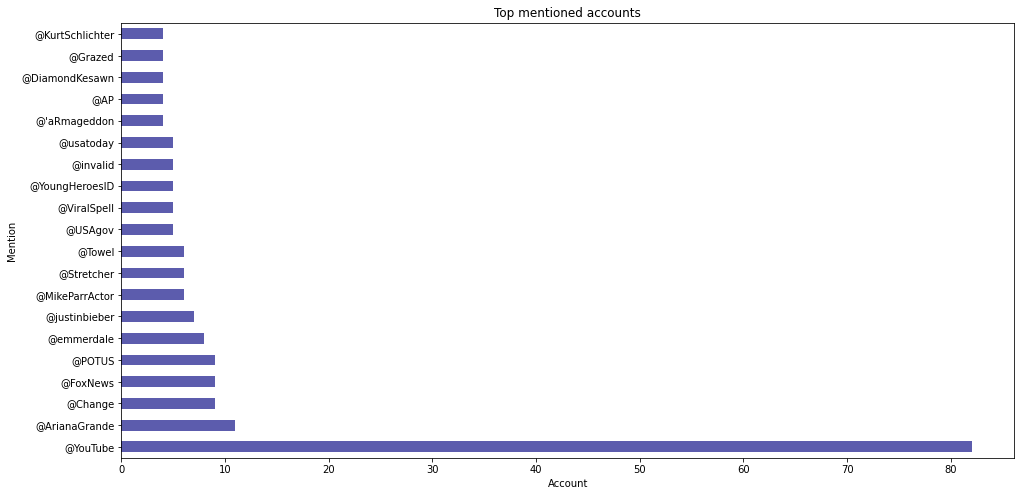

In [114]:
mentions_grouped.loc[:, 'total'].plot(kind='barh',  rot=0, title='Top mentioned accounts', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Mention')
ax.set_xlabel('Account')

Text(0.5, 0, 'Account')

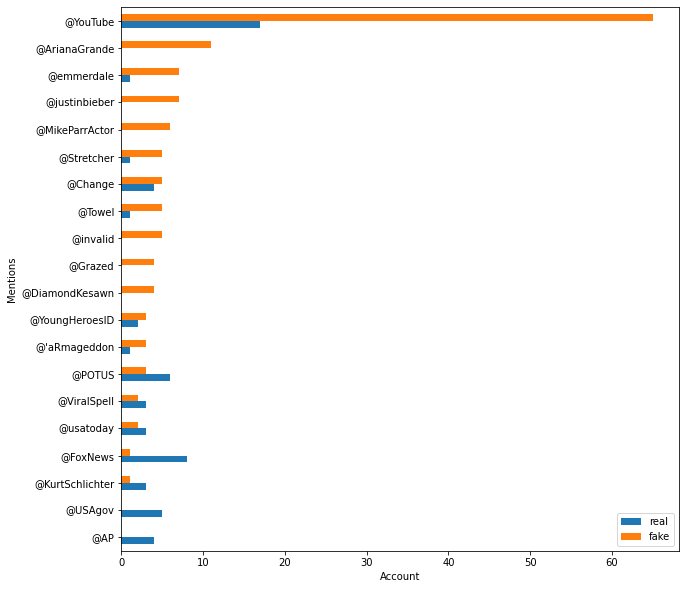

In [115]:
ax = mentions_grouped.sort_values(by=['fake']).loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))
ax.set_ylabel('Mentions')
ax.set_xlabel('Account')

### Relacion real-falso con location, keyword vacías

In [116]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [117]:
no_location = tweets[tweets['location'].isnull()]
no_keyword = tweets[tweets['keyword'].isnull()]

In [118]:
no_location.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [119]:
no_keyword.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [120]:
no_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2452 non-null   int64 
 1   keyword   2396 non-null   object
 2   location  0 non-null      object
 3   text      2452 non-null   object
 4   target    2452 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 114.9+ KB


In [121]:
no_keyword.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        56 non-null     int64 
 1   keyword   0 non-null      object
 2   location  0 non-null      object
 3   text      56 non-null     object
 4   target    56 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.6+ KB


In [122]:
no_location['len'] = no_location['text'].str.len()

<ipython-input-122-5035dc685ef4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_location['len'] = no_location['text'].str.len()


In [123]:
no_location.head()

,id,keyword,location,text,target,len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


Text(0, 0.5, 'Largo del tweet')

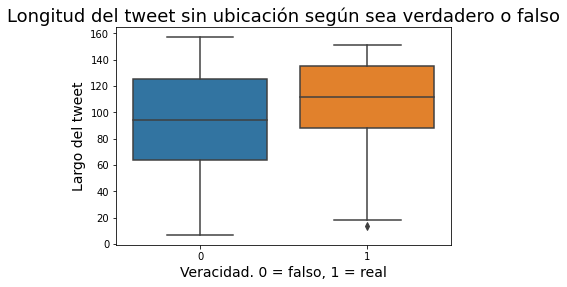

In [124]:
ax = sns.boxplot(x="target", y="len", data=no_location)
ax.set_title("Longitud del tweet sin ubicación según sea verdadero o falso", fontsize=18)
ax.set_xlabel("Veracidad. 0 = falso, 1 = real", fontsize=14)
ax.set_ylabel("Largo del tweet", fontsize=14)